#### This is a time series analysis on power comsumption. The data is hourly unit. XGBoost, Lasso, Ridge, ElasticNet and Prophet are models used here. We will use hourly consumption from 2005 to 2016 to predict 2017's hourly consumption. 

Kaggle Dataset https://www.kaggle.com/robikscube/hourly-energy-consumption

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score

from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# use mean_absolute_percentage_error as our metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
df = pd.read_csv('AEP_hourly.csv.zip', index_col = 0,parse_dates=[0])

start_date = str(df.index.min())
end_date = str(df.index.max())
print ('This hourly power consumption dataset ranges from ' + start_date + ' to ' + end_date +'.')

This hourly power consumption dataset ranges from 2004-10-01 01:00:00 to 2018-08-03 00:00:00.


In [4]:
df = df.sort_index()
df_sub = df.loc[pd.Timestamp('2005-01-01'):pd.Timestamp('2017-12-31')]
start_date = str(df_sub.index.min())
end_date = str(df_sub.index.max())
print ('This new hourly power consumption dataset ranges from ' + start_date + ' to ' + end_date +'.')

This new hourly power consumption dataset ranges from 2005-01-01 00:00:00 to 2017-12-31 00:00:00.


In [5]:
df_sub.sort_index().head()

,AEP_MW
Datetime,
2005-01-01 00:00:00,12892.0
2005-01-01 01:00:00,12316.0
2005-01-01 02:00:00,11890.0
2005-01-01 03:00:00,11579.0
2005-01-01 04:00:00,11461.0


In [6]:
# Train-Test Split to prevent leakage
data = df_sub.loc['2005-1':'2016-12']
test = df_sub.loc['2017-1-1':]

In [7]:
# generate lag features
def lag_features (data):
    for i in range(6, 25):
        data["lag_{}".format(i)] = data.AEP_MW.shift(i)
    return data

In [8]:
data = lag_features(data)
test = lag_features(test)
data = data.dropna()
test = test.dropna()

C:\Users\May Xiao\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [9]:
data.head()

,AEP_MW,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Datetime,,,,,,,,,,,,,,,,,,,,
2005-01-02 00:00:00,12849.0,14319.0,13449.0,13159.0,13340.0,13446.0,13665.0,13617.0,13455.0,12997.0,12396.0,12209.0,11898.0,11571.0,11472.0,11461.0,11579.0,11890.0,12316.0,12892.0
2005-01-02 01:00:00,12291.0,14536.0,14319.0,13449.0,13159.0,13340.0,13446.0,13665.0,13617.0,13455.0,12997.0,12396.0,12209.0,11898.0,11571.0,11472.0,11461.0,11579.0,11890.0,12316.0
2005-01-02 02:00:00,11917.0,14454.0,14536.0,14319.0,13449.0,13159.0,13340.0,13446.0,13665.0,13617.0,13455.0,12997.0,12396.0,12209.0,11898.0,11571.0,11472.0,11461.0,11579.0,11890.0
2005-01-02 03:00:00,11681.0,14248.0,14454.0,14536.0,14319.0,13449.0,13159.0,13340.0,13446.0,13665.0,13617.0,13455.0,12997.0,12396.0,12209.0,11898.0,11571.0,11472.0,11461.0,11579.0
2005-01-02 04:00:00,11613.0,13970.0,14248.0,14454.0,14536.0,14319.0,13449.0,13159.0,13340.0,13446.0,13665.0,13617.0,13455.0,12997.0,12396.0,12209.0,11898.0,11571.0,11472.0,11461.0


In [10]:
# create hour, day, month etc. features for modeling
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['is_weekend'] = df['date'].dt.weekday.isin([5,6])*1
    
    X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','is_weekend', \
            'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',\
            'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
            'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24']]
    if label:
        y = df[label]
        return X, y
    return X

In [11]:
X_train, y_train = create_features(data, label='AEP_MW')
X_test, y_test = create_features(test, label='AEP_MW')

In [12]:
X_train.tail() # dataset looks good

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Datetime,,,,,,,,,,,,,,,,,,,,,
2016-12-31 19:00:00,19,5,4,12,2016,366,31,52,1,15170.0,...,14591.0,14514.0,14588.0,14877.0,15416.0,15917.0,16422.0,16630.0,16751.0,16837.0
2016-12-31 20:00:00,20,5,4,12,2016,366,31,52,1,15040.0,...,14604.0,14591.0,14514.0,14588.0,14877.0,15416.0,15917.0,16422.0,16630.0,16751.0
2016-12-31 21:00:00,21,5,4,12,2016,366,31,52,1,14908.0,...,14739.0,14604.0,14591.0,14514.0,14588.0,14877.0,15416.0,15917.0,16422.0,16630.0
2016-12-31 22:00:00,22,5,4,12,2016,366,31,52,1,14866.0,...,15170.0,14739.0,14604.0,14591.0,14514.0,14588.0,14877.0,15416.0,15917.0,16422.0
2016-12-31 23:00:00,23,5,4,12,2016,366,31,52,1,15030.0,...,15555.0,15170.0,14739.0,14604.0,14591.0,14514.0,14588.0,14877.0,15416.0,15917.0


### Exploratory data analysis

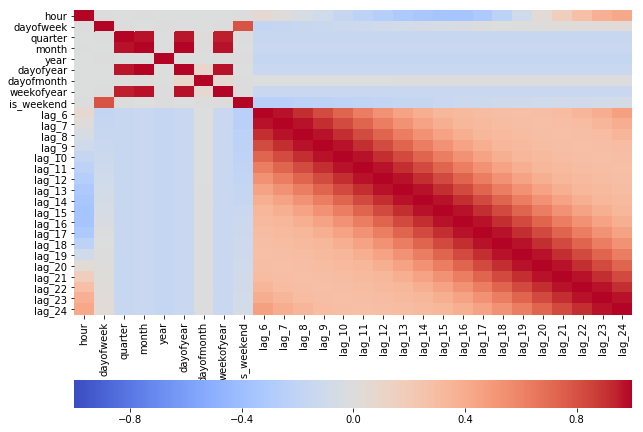

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(),
            vmin=-1, vmax=1, center= 0,
            cmap='coolwarm',
           cbar_kws= {'orientation': 'horizontal'})
plt.show()

lag_6 and lag_24, hour and lag_24 are positively correlated. 

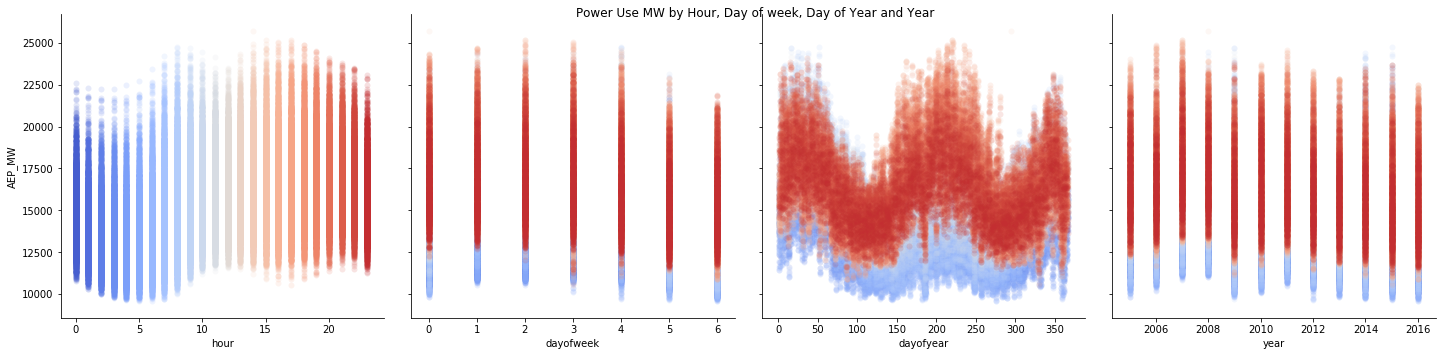

In [14]:
features_and_target = pd.concat([X_train,y_train], axis=1)
g = sns.pairplot(features_and_target.dropna(),
                 size=5,
                 hue='hour',
                 x_vars=['hour','dayofweek','dayofyear','year',],
                 y_vars='AEP_MW',
                 plot_kws={'alpha':0.15, 'linewidth':0},
                 palette = sns.color_palette("coolwarm", 24))
g._legend.remove()
plt.suptitle('Power Use MW by Hour, Day of week, Day of Year and Year')
plt.show()

The highest power use centers on hours after 1pm, peaks in Tuesday and Wednesday and boosts in summer and winter  

#### Data preparation before modeling

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # standardized features since we have large differences between their ranges

In [16]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\May Xiao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\May Xiao\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\May Xiao\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  


In [17]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "y", label="prediction", linewidth=2.0, alpha=0.8)
    plt.plot(y_test.values, "b", label="actual", linewidth=2.0, alpha=0.6)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.2)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.feature_importances_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [20]:
tscv = TimeSeriesSplit(n_splits=5) #created validation dataset for grid search and parameter tuning

In [18]:
reg = xgb.XGBRegressor(n_estimators=1000) # use XGBoost regression
reg.fit(X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

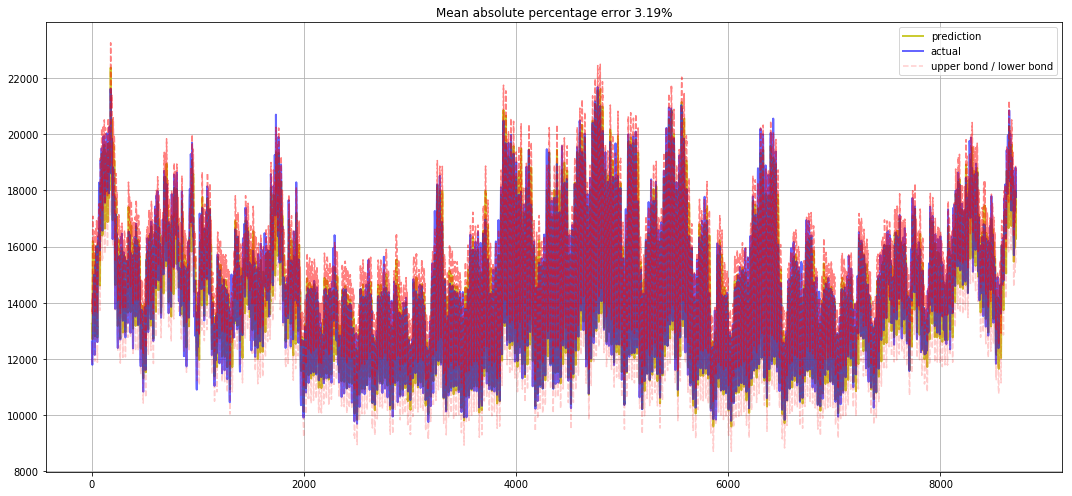

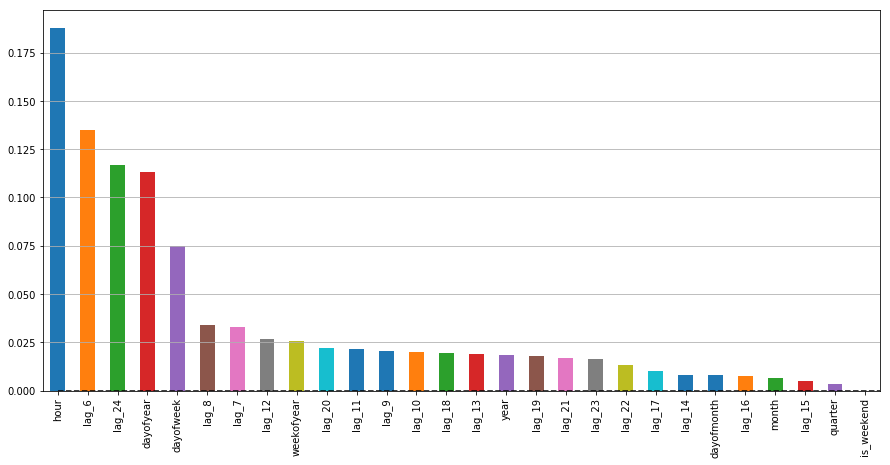

In [21]:
plotModelResults(reg, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(reg)

'hour', 'lag_6', 'lag_24', 'dayofyear' and 'dayofweek' are the important features in prediction.

### Let's try XGBoost with Gridsearch Parameters

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = tscv,
                        n_jobs = 5,
                        verbose=False)

xgb_grid.fit(X_train_scaled, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.9368736834587092
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


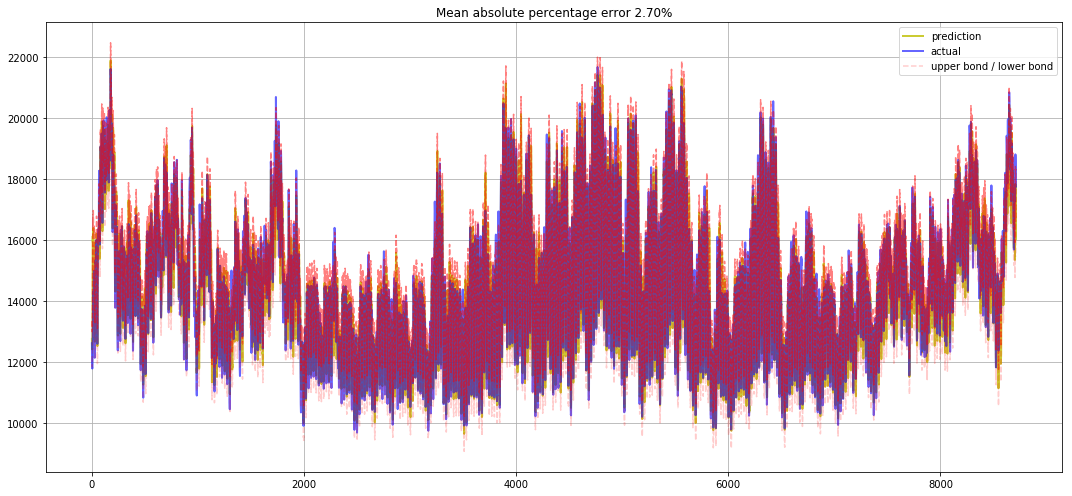

In [24]:
plotModelResults(xgb_grid, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True) #plot model fitting

#### Mean absolute percentage error drops to 2.7%! Gridsearch improves!

In [25]:
def plotCoefficients_GScv(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.best_estimator_.feature_importances_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

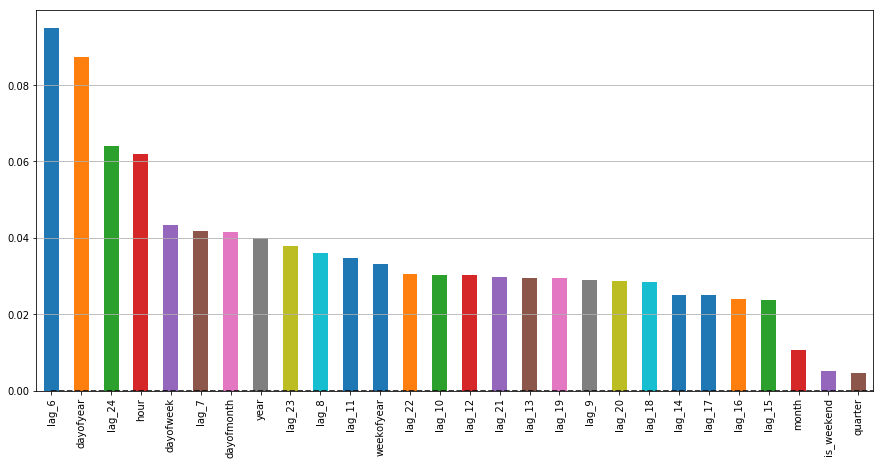

In [26]:
plotCoefficients_GScv(xgb_grid)

#### It seems lag_6, dayofyear and lag_24 have higher predict power.

### Next, we use regression models

In [27]:
def plotCoefficients_1(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

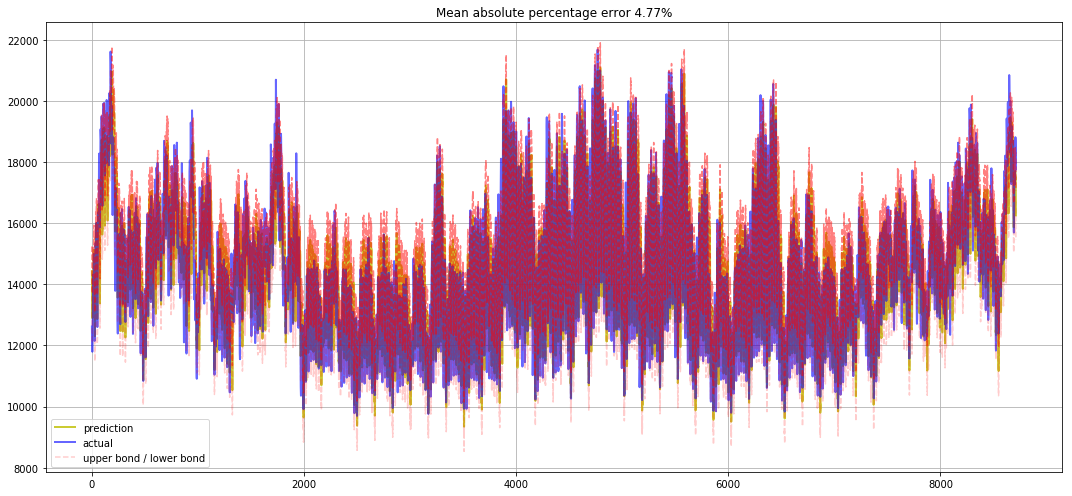

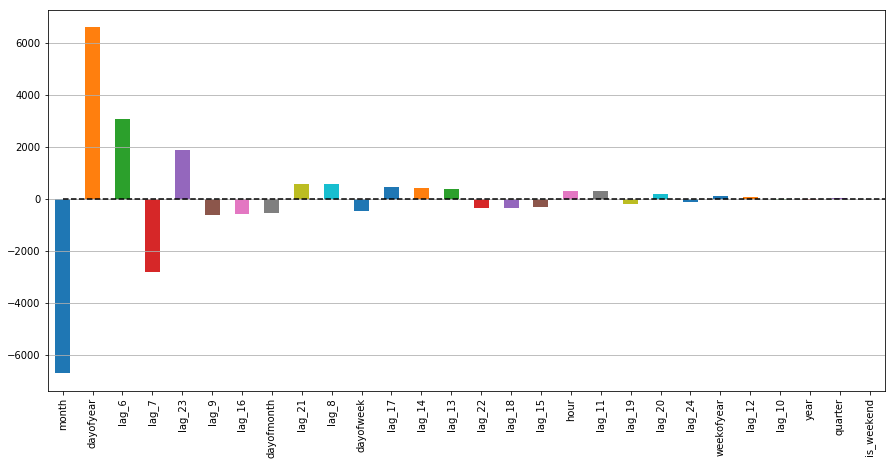

In [28]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients_1(ridge)

C:\Users\May Xiao\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\May Xiao\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


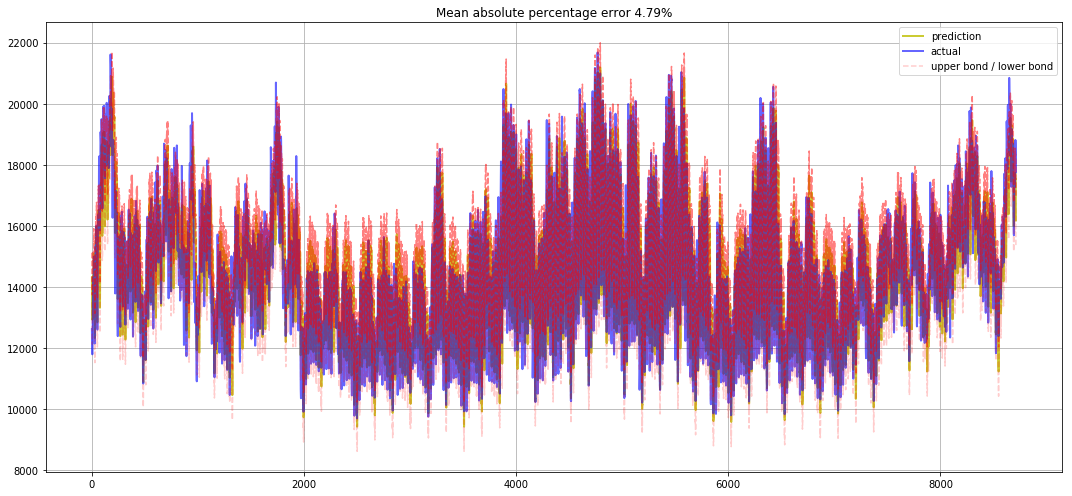

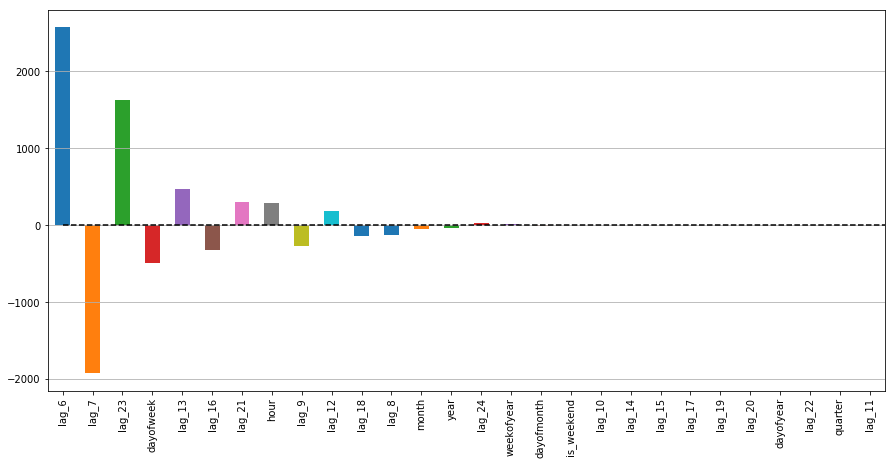

In [29]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients_1(lasso)

In [30]:
from sklearn.linear_model import ElasticNetCV

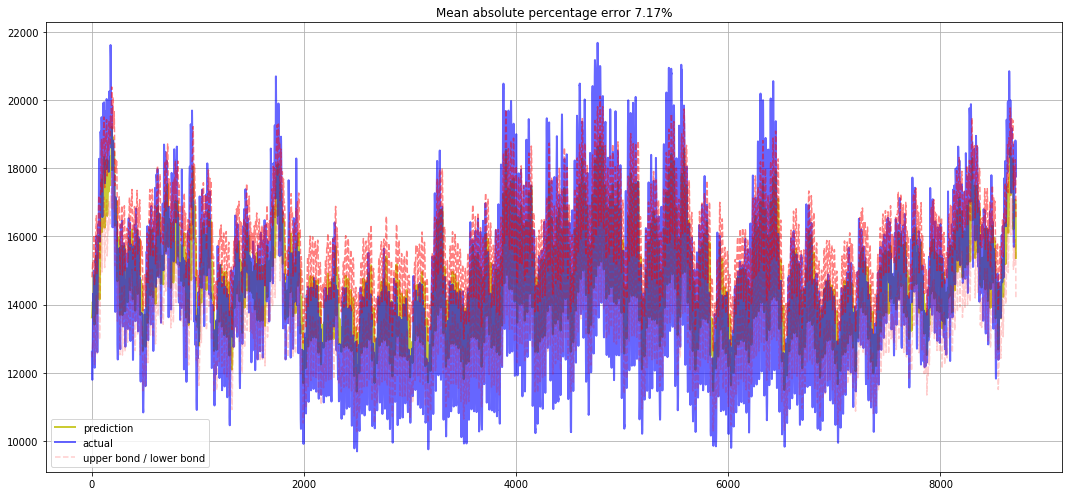

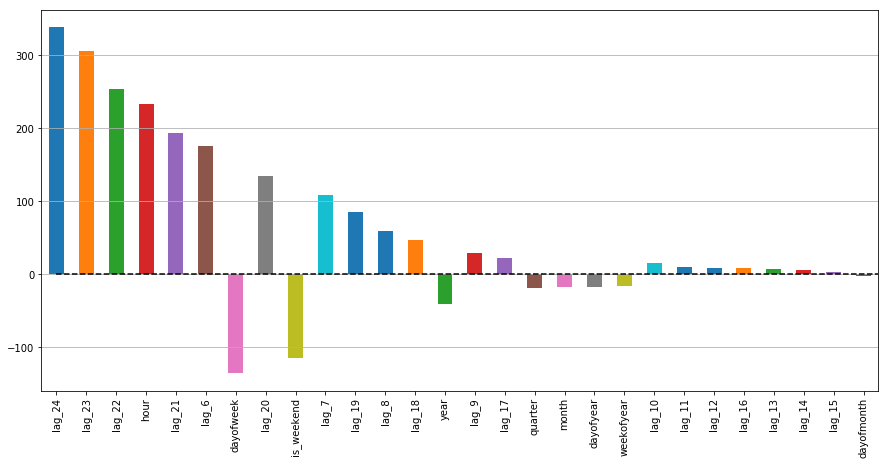

In [31]:
Elastic_Net = ElasticNetCV(cv=tscv)
Elastic_Net.fit(X_train_scaled, y_train)

plotModelResults(Elastic_Net, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients_1(Elastic_Net)

#### Ridge and lasso returns similar mean absolute percentage error. ElasticNet performance is worse and put too much weights on lag_23, lag_22 and lag_21.

### Ok, let's get hands on Prophet! 
What is Prophet? Prophet is a facebooks’ open source time series prediction. Prophet decomposes time series into trend, seasonality and holiday. It has intuitive hyper parameters which are easy to tune. 
#### Prophet time series = Trend + Seasonality + Holiday + error
Trend models non periodic changes in the value of the time series.
Seasonality is the periodic changes like daily, weekly, or yearly seasonality.
Holiday effect which occur on irregular schedules over a day or a period of days.
Error terms is what is not explained by the model.

In [32]:
from fbprophet import Prophet

model = Prophet()
model.fit(data.reset_index().rename(columns={'Datetime':'ds','AEP_MW':'y'})) #prophet has a specific column name requirment 

C:\Users\May Xiao\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [33]:
test_fcst = model.predict(df=test.reset_index().rename(columns={'Datetime':'ds'}))

In [34]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-02 00:00:00,14679.229644,11844.631063,15968.128660,14679.229644,14679.229644,-705.455200,-705.455200,-705.455200,-756.254233,...,-579.389192,-579.389192,-579.389192,630.188225,630.188225,630.188225,0.0,0.0,0.0,13973.774444
1,2017-01-02 01:00:00,14679.217149,11290.002668,15105.878294,14679.217149,14679.217149,-1397.587899,-1397.587899,-1397.587899,-1529.594171,...,-501.354339,-501.354339,-501.354339,633.360611,633.360611,633.360611,0.0,0.0,0.0,13281.629250
2,2017-01-02 02:00:00,14679.204654,10654.945631,14831.641695,14679.204654,14679.204654,-1901.386527,-1901.386527,-1901.386527,-2114.650590,...,-423.293667,-423.293667,-423.293667,636.557730,636.557730,636.557730,0.0,0.0,0.0,12777.818127
3,2017-01-02 03:00:00,14679.192158,10478.272602,14566.270852,14679.192158,14679.192158,-2154.720074,-2154.720074,-2154.720074,-2448.866672,...,-345.632903,-345.632903,-345.632903,639.779501,639.779501,639.779501,0.0,0.0,0.0,12524.472085
4,2017-01-02 04:00:00,14679.179663,10638.322521,14595.221707,14679.179663,14679.179663,-2110.560727,-2110.560727,-2110.560727,-2484.799796,...,-268.786770,-268.786770,-268.786770,643.025839,643.025839,643.025839,0.0,0.0,0.0,12568.618936


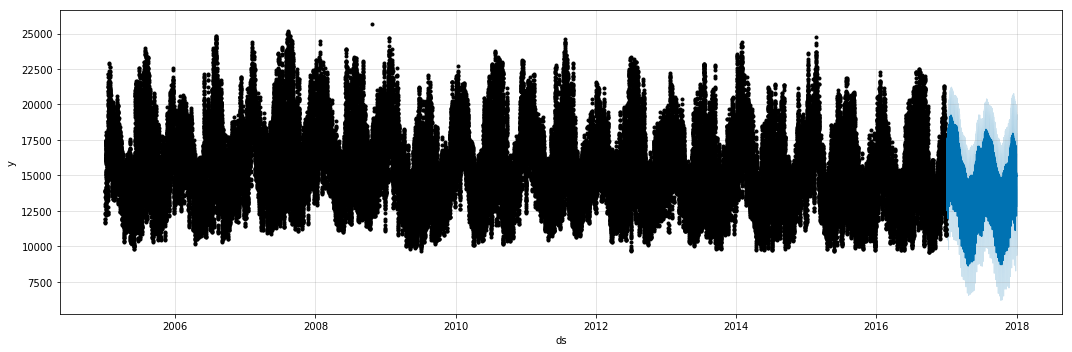

In [35]:
# Plot train and prediction
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst,
                 ax=ax)
plt.show()

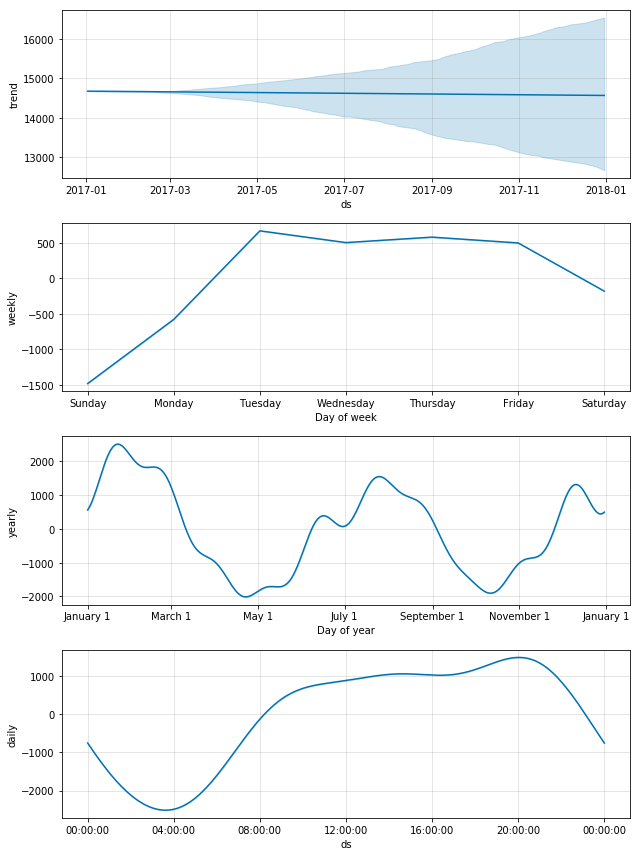

In [36]:
#Plot the components of the model
fig = model.plot_components(test_fcst)

In [37]:
mape_prophet = mean_absolute_percentage_error(test['AEP_MW'].values, test_fcst['yhat'].values)

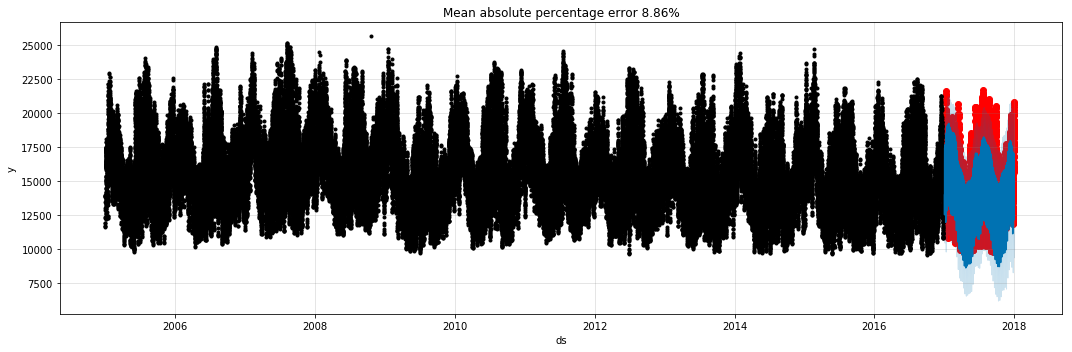

In [38]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['AEP_MW'], color='r')
plt.title("Mean absolute percentage error {0:.2f}%".format(mape_prophet))
fig = model.plot(test_fcst, ax=ax)

#### Prophet show a worser prediction with high errors, so it may not be a proper model in this case.

#### XGBoost + Gridsearch is our winner, which has lowest mean absolute percentage error 2.7%. What does this mean? When MAPE is 0, our prediction is perfect. In this case, our prediction is very closed to perfect. We did a great job!